# Consistency Models Training Example

[![arXiv](https://img.shields.io/badge/arXiv-2301.01469-<COLOR>.svg)](https://arxiv.org/abs/2303.01469) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kinyugo/consistency_models/blob/main/notebooks/consistency_models_training_example.ipynb) [![GitHub Repo stars](https://img.shields.io/github/stars/Kinyugo/consistency_models?style=social) ](https://github.com/Kinyugo/consistency_models)

## 📖 Introduction

[Consistency Models](https://arxiv.org/abs/2303.01469) are a new family of generative models that achieve high sample quality without adversarial training. They support fast one-step generation by design, while still allowing for few-step sampling to trade compute for sample quality. They also support zero-shot data editing, like image inpainting, colorization, and super-resolution, without requiring explicit training on these tasks.


### Key Idea

_Learn a model that maps any arbitrary point in the latent space to the initial data point, i.e: if points lie on the same probability flow trajectory they are mapped to the same initial data point._

### Contributions

- Single step sampling
- Zero-shot data editing: inpainting, outpainting e.t.c

### Definition

Given a diffusion trajectory $x_{\sigma \in \left[\sigma_{min}, \sigma_{max}\right]}$, we define a consistency function $f : \left(x_{\sigma}, \sigma\right) \rightarrow x_{\sigma_{min}}$.

We can then train a consistency model $f_{\theta}\left(., . \right)$ to approximate the consistency function. A property of the consistency function is that $f : \left(x_{\sigma_{min}}, \sigma_{min} \right) \rightarrow x_{\sigma_{min}}$. To achieve this we parameterize the consistency model using skip connections as in [[2]](#2)

$$
f_{\theta}\left(x_{\sigma}, \sigma \right) = c_{skip}\left(\sigma \right)x_{\sigma} + c_{out}\left(\sigma \right)F_{\theta}\left(x_{\sigma}, \sigma \right)
$$

where $c_{skip}\left(\sigma_{min} \right) = 1$ and $c_{out}\left(\sigma_{min} \right) = 0$ and $F_{\theta}\left(.,.\right)$ is the neural network.

### Algorithms

#### Training

To train the model we follow the following algorithm:

```python
for current_training_step in range(total_training_steps):
    data = data_distribution()

  num_timesteps = timestep_schedule(current_training_step, total_training_steps, initial_timesteps, final_timesteps)
  sigmas = karras_schedule(num_timesteps, sigma_min, sigma_max)
  timesteps = uniform_distribution(batch_size, start=0, end=num_timesteps-1)
  noise = standard_gaussian_noise()

  current_sigmas = sigmas[timesteps]
  next_sigmas = sigmas[timesteps + 1]

  current_noisy_data = data + current_sigmas * noise
  next_noisy_data = data + next_sigmas * noise

  student_model_prediction = (skip_scaling(next_sigmas, sigma_data, sigma_min) * next_noisy_data
                            + output_scaling(next_sigmas, sigma_data, sigma_min) * student_model(next_noisy_data, next_sigmas))

  with no_grad():
      teacher_model_prediction = (skip_scaling(current_sigmas, sigma_data, sigma_min) * current_noisy_data
                                + output_scaling(current_sigmas, sigma_data, sigma_min) * teacher_model(current_noisy_data, next_sigmas))

  loss = distance_metric(student_model_prediction, teacher_model_prediction)

  loss.backward()

  with no_grad():
    current_ema_decay_rate = ema_decay_schedule(current_training_step, initial_ema_decay_rate, initial_timesteps)
    teacher_model_params = current_ema_decay_rate * teacher_model_params + (1 - current_ema_decay_rate) * student_model_params

```

#### Sampling

Starting from an initial random noise $\hat{x}_{\sigma_{max}} \sim \mathcal{N}(0, \sigma_{max}^2I)$, the consistency model can be used to sample a point in a single step: $\hat{x}_{\sigma_{min}} = f_{\theta}(x_{\sigma_{max}}, \sigma_{max})$. For iterative refinement, the following algorithm can be used:

```python
# Generate an initial sample from the initial random noise
sample = (skip_scaling(sigma_max, sigma_data, sigma_min) * x_sigma_max
                + output_scaling(sigma_max, sigma_data, sigma_min) * model(x_sigma_max, sigma_max))
sample = clamp?(sample)

for sigma in sigmas:
    noise = standard_gaussian_noise()
    noisy_sample = sample + square_root(square(sigma) - square(sigma_min)) * noise
    sample = (skip_scaling(sigma, sigma_data, sigma_min) * noisy_sample
                + output_scaling(sigma, sigma_data, sigma_min) * model(noisy_sample, sigma))
    sample = clamp?(sample)
```

where `consistency_model` $= f_{\theta}\left(.,.\right)$,
`clamp?` is a function that optionally clips values to a given range.

### References

<a id="1">[1]</a> Song, Y., Dhariwal, P., Chen, M., &amp; Sutskever, I. (2023, May 31). Consistency models. arXiv.org. https://arxiv.org/abs/2303.01469

<a id="2">[2]</a> Karras, T., Aittala, M., Aila, T., &amp; Laine, S. (2022, October 11). Elucidating the design space of diffusion-based Generative Models. arXiv.org. https://arxiv.org/abs/2206.00364

## 🛠️ Setup


### GPU Check

In [1]:
!nvidia-smi

Thu Sep  4 07:22:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:4A:00.0 Off |                    0 |
|  0%   69C    P0            293W /  300W |   35117MiB /  46068MiB |     97%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Packages Installation

> **NOTE:** Restart the runtime if using colab after installing the packages.

In [2]:
#%pip install -q lightning gdown torchmetrics einops torchinfo lpips --no-cache --upgrade
#%pip install -q -e git+https://github.com/Kinyugo/consistency_models.git#egg=consistency_models

### Imports

In [3]:
import json
import os
from dataclasses import asdict, dataclass
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
from einops import rearrange
from einops.layers.torch import Rearrange
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from matplotlib import pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from consistency_models import (
    ConsistencySamplingAndEditing,
    ConsistencySamplingAndEditingObsCond,
    ConsistencyTraining,
    ConsistencyTrainingObsCond,
    ema_decay_rate_schedule,
)
from consistency_models.utils import update_ema_model_

## 🧠  Implementation

#### DataModule

Norm stats (0.3047108663749711, 0.3879814586804132)
torch.Size([1, 9, 128, 128])


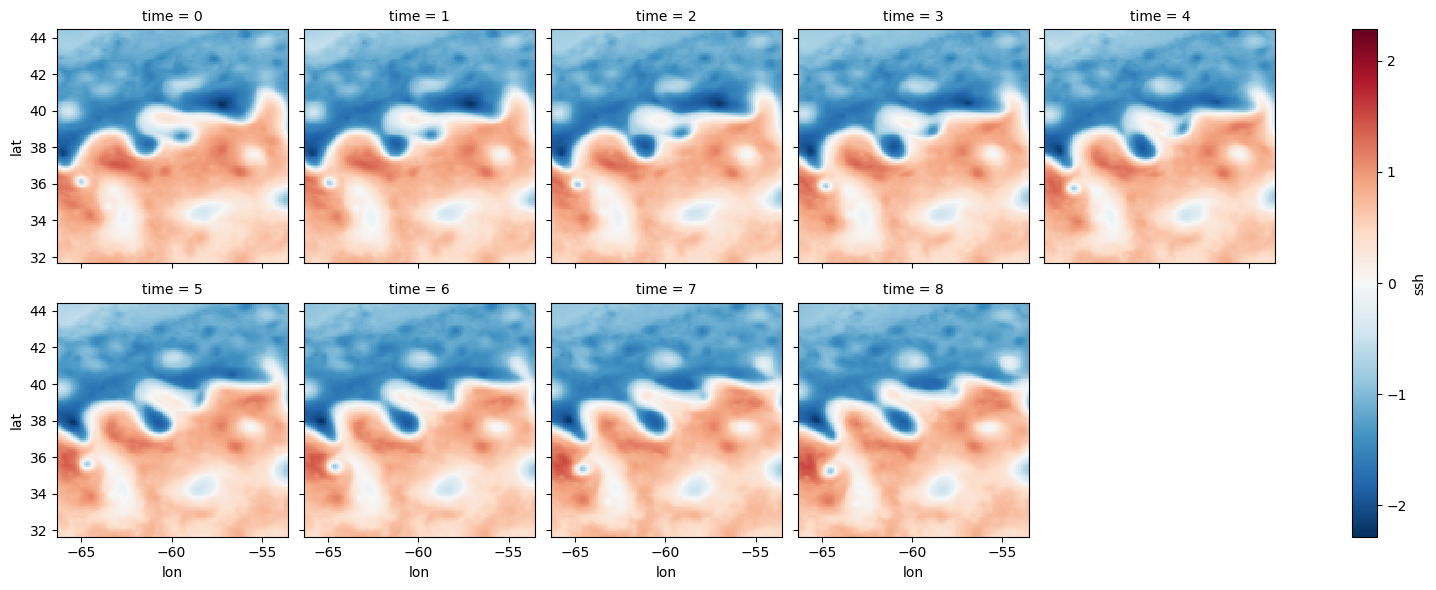

In [4]:
import sys
import pyinterp
import pyinterp.fill
import pyinterp.backends.xarray
sys.path.append('..')
from src.data_notebook import *

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66.3 
lon_max = -53.5
lat_min = 31.7
lat_max = 44.5

datadir="/dmidata/users/maxb/NATL_dataset"

TrainingItem = namedtuple('TrainingItem', ['input', 'tgt'])

def remove_nan(da):
    da["lon"] = da.lon.assign_attrs(units="degrees_east")
    da["lat"] = da.lat.assign_attrs(units="degrees_north")

    da.transpose("lon", "lat", "time")[:, :] = pyinterp.fill.gauss_seidel(
        pyinterp.backends.xarray.Grid3D(da)
    )[1]
    return da

def load_altimetry_data(path, obs_from_tgt=False):
    ds =  (
        xr.open_dataset(path)
        # .assign(ssh=lambda ds: ds.ssh.coarsen(lon=2, lat=2).mean().interp(lat=ds.lat, lon=ds.lon))
        .load()
        .assign(
            input=lambda ds: ds.nadir_obs,
            tgt=lambda ds: remove_nan(ds.ssh),
        )    
    )

    if obs_from_tgt:
        ds = ds.assign(input=ds.tgt.where(np.isfinite(ds.input), np.nan))
    
    return (
        ds[[*TrainingItem._fields]]
        .transpose("time", "lat", "lon")
        .to_array()
    )

datamodule = BaseDataModule(input_da=load_altimetry_data(datadir+"/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 128, 'lon': 128},
                                     'strides': {'time': 1, 'lat': 128, 'lon': 128},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 1, 'num_workers': 1},
                            grad=False,
                            #aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

### Modules

In [5]:
def GroupNorm(channels: int) -> nn.GroupNorm:
    return nn.GroupNorm(num_groups=min(32, channels // 4), num_channels=channels)


class SelfAttention(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        n_heads: int = 8,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.dropout = dropout

        self.qkv_projection = nn.Sequential(
            GroupNorm(in_channels),
            nn.Conv2d(in_channels, 3 * in_channels, kernel_size=1, bias=False),
            Rearrange("b (i h d) x y -> i b h (x y) d", i=3, h=n_heads),
        )
        self.output_projection = nn.Sequential(
            Rearrange("b h l d -> b l (h d)"),
            nn.Linear(in_channels, out_channels, bias=False),
            Rearrange("b l d -> b d l"),
            GroupNorm(out_channels),
            nn.Dropout1d(dropout),
        )
        self.residual_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        q, k, v = self.qkv_projection(x).unbind(dim=0)

        output = F.scaled_dot_product_attention(
            q, k, v, dropout_p=self.dropout if self.training else 0.0, is_causal=False
        )
        output = self.output_projection(output)
        output = rearrange(output, "b c (x y) -> b c x y", x=x.shape[-2], y=x.shape[-1])

        return output + self.residual_projection(x)


class UNetBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        noise_level_channels: int,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.input_projection = nn.Sequential(
            GroupNorm(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.Dropout2d(dropout),
        )
        self.noise_level_projection = nn.Sequential(
            nn.SiLU(),
            nn.Conv2d(noise_level_channels, out_channels, kernel_size=1),
        )
        self.output_projection = nn.Sequential(
            GroupNorm(out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same"),
            nn.Dropout2d(dropout),
        )
        self.residual_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: Tensor, noise_level: Tensor) -> Tensor:
        h = self.input_projection(x)
        h = h + self.noise_level_projection(noise_level)

        return self.output_projection(h) + self.residual_projection(x)


class UNetBlockWithSelfAttention(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        noise_level_channels: int,
        n_heads: int = 8,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.unet_block = UNetBlock(
            in_channels, out_channels, noise_level_channels, dropout
        )
        self.self_attention = SelfAttention(
            out_channels, out_channels, n_heads, dropout
        )

    def forward(self, x: Tensor, noise_level: Tensor) -> Tensor:
        return self.self_attention(self.unet_block(x, noise_level))


class Downsample(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()

        self.projection = nn.Sequential(
            Rearrange("b c (h ph) (w pw) -> b (c ph pw) h w", ph=2, pw=2),
            nn.Conv2d(4 * channels, channels, kernel_size=1),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.projection(x)


class Upsample(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()

        self.projection = nn.Sequential(
            nn.Upsample(scale_factor=2.0, mode="nearest"),
            nn.Conv2d(channels, channels, kernel_size=3, padding="same"),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.projection(x)


class NoiseLevelEmbedding(nn.Module):
    def __init__(self, channels: int, scale: float = 16.0) -> None:
        super().__init__()

        self.W = nn.Parameter(torch.randn(channels // 2) * scale, requires_grad=False)

        self.projection = nn.Sequential(
            nn.Linear(channels, 4 * channels),
            nn.SiLU(),
            nn.Linear(4 * channels, channels),
            Rearrange("b c -> b c () ()"),
        )

    def forward(self, x: Tensor) -> Tensor:
        h = x[:, None] * self.W[None, :] * 2 * torch.pi
        h = torch.cat([torch.sin(h), torch.cos(h)], dim=-1)

        return self.projection(h)

### UNet

Our UNet is inspired by Stable Diffusion and Imagen. It's not the same UNet as the paper.

In [6]:
@dataclass
class UNetConfig:
    channels: int = 9
    noise_level_channels: int = 256
    noise_level_scale: float = 16.0
    n_heads: int = 8
    top_blocks_channels: Tuple[int, ...] = (128, 128)
    top_blocks_n_blocks_per_resolution: Tuple[int, ...] = (2, 2)
    top_blocks_has_resampling: Tuple[bool, ...] = (True, True)
    top_blocks_dropout: Tuple[float, ...] = (0.0, 0.0)
    mid_blocks_channels: Tuple[int, ...] = (256, 512)
    mid_blocks_n_blocks_per_resolution: Tuple[int, ...] = (4, 4)
    mid_blocks_has_resampling: Tuple[bool, ...] = (True, False)
    mid_blocks_dropout: Tuple[float, ...] = (0.0, 0.0)

class UNet(nn.Module):
    def __init__(self, config: UNetConfig) -> None:
        super().__init__()

        self.config = config

        self.input_projection = nn.Conv2d(
            config.channels*3,
            config.top_blocks_channels[0],
            kernel_size=3,
            padding="same",
        )
        self.noise_level_embedding = NoiseLevelEmbedding(
            config.noise_level_channels, config.noise_level_scale
        )
        self.top_encoder_blocks = self._make_encoder_blocks(
            self.config.top_blocks_channels + self.config.mid_blocks_channels[:1],
            self.config.top_blocks_n_blocks_per_resolution,
            self.config.top_blocks_has_resampling,
            self.config.top_blocks_dropout,
            self._make_top_block,
        )
        self.mid_encoder_blocks = self._make_encoder_blocks(
            self.config.mid_blocks_channels + self.config.mid_blocks_channels[-1:],
            self.config.mid_blocks_n_blocks_per_resolution,
            self.config.mid_blocks_has_resampling,
            self.config.mid_blocks_dropout,
            self._make_mid_block,
        )
        self.mid_decoder_blocks = self._make_decoder_blocks(
            self.config.mid_blocks_channels + self.config.mid_blocks_channels[-1:],
            self.config.mid_blocks_n_blocks_per_resolution,
            self.config.mid_blocks_has_resampling,
            self.config.mid_blocks_dropout,
            self._make_mid_block,
        )
        self.top_decoder_blocks = self._make_decoder_blocks(
            self.config.top_blocks_channels + self.config.mid_blocks_channels[:1],
            self.config.top_blocks_n_blocks_per_resolution,
            self.config.top_blocks_has_resampling,
            self.config.top_blocks_dropout,
            self._make_top_block,
        )
        self.output_projection = nn.Conv2d(
            config.top_blocks_channels[0],
            config.channels,
            kernel_size=3,
            padding="same",
        )

    def forward(self, x: Tensor, 
                      y: Tensor,
                      mask_y: Tensor,
                      noise_level: Tensor) -> Tensor:
        
        h = self.input_projection(torch.cat((x,y,mask_y),dim=1))
        noise_level = self.noise_level_embedding(noise_level)

        top_encoder_embeddings = []
        for block in self.top_encoder_blocks:
            if isinstance(block, UNetBlock):
                h = block(h, noise_level)
                top_encoder_embeddings.append(h)
            else:
                h = block(h)

        mid_encoder_embeddings = []
        for block in self.mid_encoder_blocks:
            if isinstance(block, UNetBlockWithSelfAttention):
                h = block(h, noise_level)
                mid_encoder_embeddings.append(h)
            else:
                h = block(h)

        for block in self.mid_decoder_blocks:
            if isinstance(block, UNetBlockWithSelfAttention):
                h = torch.cat((h, mid_encoder_embeddings.pop()), dim=1)
                h = block(h, noise_level)
            else:
                h = block(h)

        for block in self.top_decoder_blocks:
            if isinstance(block, UNetBlock):
                h = torch.cat((h, top_encoder_embeddings.pop()), dim=1)
                h = block(h, noise_level)
            else:
                h = block(h)

        return self.output_projection(h)

    def _make_encoder_blocks(
        self,
        channels: Tuple[int, ...],
        n_blocks_per_resolution: Tuple[int, ...],
        has_resampling: Tuple[bool, ...],
        dropout: Tuple[float, ...],
        block_fn: Callable[[], nn.Module],
    ) -> nn.ModuleList:
        blocks = nn.ModuleList()

        channel_pairs = list(zip(channels[:-1], channels[1:]))
        for idx, (in_channels, out_channels) in enumerate(channel_pairs):
            for _ in range(n_blocks_per_resolution[idx]):
                blocks.append(block_fn(in_channels, out_channels, dropout[idx]))
                in_channels = out_channels

            if has_resampling[idx]:
                blocks.append(Downsample(out_channels))

        return blocks

    def _make_decoder_blocks(
        self,
        channels: Tuple[int, ...],
        n_blocks_per_resolution: Tuple[int, ...],
        has_resampling: Tuple[bool, ...],
        dropout: Tuple[float, ...],
        block_fn: Callable[[], nn.Module],
    ) -> nn.ModuleList:
        blocks = nn.ModuleList()

        channel_pairs = list(zip(channels[:-1], channels[1:]))[::-1]
        for idx, (out_channels, in_channels) in enumerate(channel_pairs):
            if has_resampling[::-1][idx]:
                blocks.append(Upsample(in_channels))

            inner_blocks = []
            for _ in range(n_blocks_per_resolution[::-1][idx]):
                inner_blocks.append(
                    block_fn(in_channels * 2, out_channels, dropout[::-1][idx])
                )
                out_channels = in_channels
            blocks.extend(inner_blocks[::-1])

        return blocks

    def _make_top_block(
        self, in_channels: int, out_channels: int, dropout: float
    ) -> UNetBlock:
        return UNetBlock(
            in_channels,
            out_channels,
            self.config.noise_level_channels,
            dropout,
        )

    def _make_mid_block(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float,
    ) -> UNetBlockWithSelfAttention:
        return UNetBlockWithSelfAttention(
            in_channels,
            out_channels,
            self.config.noise_level_channels,
            self.config.n_heads,
            dropout,
        )

    def save_pretrained(self, pretrained_path: str) -> None:
        os.makedirs(pretrained_path, exist_ok=True)

        with open(os.path.join(pretrained_path, "config.json"), mode="w") as f:
            json.dump(asdict(self.config), f)

        torch.save(self.state_dict(), os.path.join(pretrained_path, "model.pt"))

    @classmethod
    def from_pretrained(cls, pretrained_path: str) -> "UNet":
        with open(os.path.join(pretrained_path, "config.json"), mode="r") as f:
            config_dict = json.load(f)
        config = UNetConfig(**config_dict)

        model = cls(config)

        state_dict = torch.load(
            os.path.join(pretrained_path, "model.pt"), map_location=torch.device("cpu")
        )
        model.load_state_dict(state_dict)

        return model


summary(UNet(UNetConfig()), 
        input_size=((1, 9, 256, 256), 
                    (1, 9, 256, 256), 
                    (1, 9, 256, 256), 
                    (1,)
                   )
       )

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 9, 256, 256]          --
├─Conv2d: 1-1                                 [1, 128, 256, 256]        31,232
├─NoiseLevelEmbedding: 1-2                    [1, 256, 1, 1]            128
│    └─Sequential: 2-1                        [1, 256, 1, 1]            --
│    │    └─Linear: 3-1                       [1, 1024]                 263,168
│    │    └─SiLU: 3-2                         [1, 1024]                 --
│    │    └─Linear: 3-3                       [1, 256]                  262,400
│    │    └─Rearrange: 3-4                    [1, 256, 1, 1]            --
├─ModuleList: 1-3                             --                        --
│    └─UNetBlock: 2-2                         [1, 128, 256, 256]        --
│    │    └─Sequential: 3-5                   [1, 128, 256, 256]        147,840
│    │    └─Sequential: 3-6                   [1, 128, 1, 1]            32,

### LitUNet

In [7]:
@dataclass
class LitConsistencyModelConfig:
    initial_ema_decay_rate: float = 0.95
    student_model_ema_decay_rate: float = 0.99993
    lr: float = 1e-4
    betas: Tuple[float, float] = (0.9, 0.995)
    lr_scheduler_start_factor: float = 1e-5
    lr_scheduler_iters: int = 10_000
    sample_every_n_steps: int = 10_000
    num_samples: int = 8
    sampling_sigmas: Tuple[Tuple[int, ...], ...] = (
        (80,),
        (80.0, 0.661),
        (80.0, 24.4, 5.84, 0.9, 0.661),
    )


class LitConsistencyModel(LightningModule):
    def __init__(
        self,
        consistency_training: ConsistencyTrainingObsCond,
        consistency_sampling: ConsistencySamplingAndEditingObsCond,
        student_model: UNet,
        teacher_model: UNet,
        ema_student_model: UNet,
        config: LitConsistencyModelConfig,
    ) -> None:
        super().__init__()

        self.consistency_training = consistency_training
        self.consistency_sampling = consistency_sampling
        self.student_model = student_model
        self.teacher_model = teacher_model
        self.ema_student_model = ema_student_model
        self.config = config
        self.num_timesteps = self.consistency_training.initial_timesteps

        self.lpips = LearnedPerceptualImagePatchSimilarity(net_type="alex")

        # Freeze teacher and EMA student models and set to eval mode
        for param in self.teacher_model.parameters():
            param.requires_grad = False
        for param in self.ema_student_model.parameters():
            param.requires_grad = False
        self.teacher_model = self.teacher_model.eval()
        self.ema_student_model = self.ema_student_model.eval()

    def training_step(self, batch: Union[Tensor, List[Tensor]], batch_idx: int) -> None:
        if isinstance(batch, list):
            batch = batch[0]

        output = self.consistency_training(
            self.student_model,
            self.teacher_model,
            batch.tgt,
            batch.input.nan_to_num(),
            ~torch.isnan(batch.input.nan_to_num()),            
            self.global_step,
            10000,
            #self.trainer.max_steps,
        )
        self.num_timesteps = output.num_timesteps

        """
        lpips_loss = self.lpips(
            output.predicted.clamp(-1.0, 1.0), output.target.clamp(-1.0, 1.0)
        )
        overflow_loss = F.mse_loss(
            output.predicted, output.predicted.detach().clamp(-1.0, 1.0)
        )
        loss = lpips_loss + overflow_loss
        """
        mse_loss = F.mse_loss(
            output.predicted, output.target
        )
        loss = mse_loss
        
        self.log_dict(
            {
                "train_loss": loss,
                #"lpips_loss": lpips_loss,
                #"overflow_loss": overflow_loss,
                "num_timesteps": output.num_timesteps,
            }
        )

        return loss

    def on_train_batch_end(
        self, outputs: Any, batch: Union[Tensor, List[Tensor]], batch_idx: int
    ) -> None:
        # Update teacher model
        ema_decay_rate = ema_decay_rate_schedule(
            self.num_timesteps,
            self.config.initial_ema_decay_rate,
            self.consistency_training.initial_timesteps,
        )
        update_ema_model_(self.teacher_model, self.student_model, ema_decay_rate)
        self.log_dict({"ema_decay_rate": ema_decay_rate})

        # Update EMA student model
        update_ema_model_(
            self.ema_student_model,
            self.student_model,
            self.config.student_model_ema_decay_rate,
        )

        if (
            (self.global_step + 1) % self.config.sample_every_n_steps == 0
        ) or self.global_step == 0:
            self.__sample_and_log_samples(batch)

    def configure_optimizers(self):
        opt = torch.optim.Adam(
            self.student_model.parameters(), lr=self.config.lr, betas=self.config.betas
        )
        sched = torch.optim.lr_scheduler.LinearLR(
            opt,
            start_factor=self.config.lr_scheduler_start_factor,
            total_iters=self.config.lr_scheduler_iters,
        )
        sched = {"scheduler": sched, "interval": "step", "frequency": 1}

        return [opt], [sched]

    @torch.no_grad()
    def __sample_and_log_samples(self, batch: Union[Tensor, List[Tensor]]) -> None:
        if isinstance(batch, list):
            batch = batch[0]

        # Ensure the number of samples does not exceed the batch size
        num_samples = min(self.config.num_samples, batch.tgt.shape[0])
        noise = torch.randn_like(batch.tgt[:num_samples])

        # Log ground truth samples
        #self.__log_images(
        #    batch[:num_samples].detach().clone(), f"ground_truth", self.global_step
        #)

        for sigmas in self.config.sampling_sigmas:
            samples = self.consistency_sampling(
                self.ema_student_model, 
                noise,
                batch.input.nan_to_num(),
                ~torch.isnan(batch.input.nan_to_num()),   
                sigmas, 
                clip_denoised=False, 
                verbose=True
            )
            #samples = samples.clamp(min=-1.0, max=1.0)

            # Generated samples
            #self.__log_images(
            #    samples,
            #    f"generated_samples-sigmas={sigmas}",
            #    self.global_step,
            #)

    @torch.no_grad()
    def __log_images(self, images: Tensor, title: str, global_step: int) -> None:
        images = images.detach().float()

        grid = make_grid(
            images.clamp(-1.0, 1.0), value_range=(-1.0, 1.0), normalize=True
        )
        self.logger.experiment.add_image(title, grid, global_step)

## 🚀 Training

### Training Loop

In [8]:
@dataclass
class TrainingConfig:
    unet_config: UNetConfig
    consistency_training: ConsistencyTrainingObsCond
    consistency_sampling: ConsistencySamplingAndEditingObsCond
    lit_cm_config: LitConsistencyModelConfig
    trainer: Trainer
    seed: int = 42
    model_ckpt_path: str = "checkpoints/cm"
    resume_ckpt_path: Optional[str] = None
    reload: Optional[bool] = False

def run_training(config: TrainingConfig) -> None:
    # Set seed
    seed_everything(config.seed)

    # Create data module
    dm = datamodule

    # Create student and teacher models and EMA student model
    if not config.reload:
        student_model = UNet(config.unet_config)
    else:
        student_model = UNet.from_pretrained(config.model_ckpt_path)
    teacher_model = UNet(config.unet_config)
    teacher_model.load_state_dict(student_model.state_dict())
    ema_student_model = UNet(config.unet_config)
    ema_student_model.load_state_dict(student_model.state_dict())

    # Create lightning module
    lit_cm = LitConsistencyModel(
        config.consistency_training,
        config.consistency_sampling,
        student_model,
        teacher_model,
        ema_student_model,
        config.lit_cm_config,
    )

    # Run training
    config.trainer.fit(lit_cm, dm, ckpt_path=config.resume_ckpt_path)

    # Save model
    lit_cm.ema_student_model.save_pretrained(config.model_ckpt_path)

### Run Training

In [86]:
%load_ext tensorboard
%tensorboard --logdir=logs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...


KeyboardInterrupt



> **NOTE:** While the paper suggests a final_timesteps value of `150`, it's important to note that during my experimentation on a smaller dataset with approximately 10,000 training steps, I discovered that setting final_timesteps to `17` yielded superior results. This value corresponds to the number of timesteps that would be obtained if we were to train for the same number of steps as mentioned in the paper (600,000 to 1,000,000). However, it's crucial to emphasize that this particular setting has not been extensively explored or experimented with, so it may require further fine-tuning and adjustment to suit your specific needs.

In [17]:
from pytorch_lightning.accelerators import find_usable_cuda_devices

#ckpt = torch.load("checkpoints/cm/model.pt", map_location="cpu")
#ckpt["pytorch-lightning_version"] = "2.0.9" 
#torch.save(ckpt, "checkpoints/cm/model.pt")

training_config = TrainingConfig(
    unet_config=UNetConfig(),
    consistency_training=ConsistencyTrainingObsCond(final_timesteps=17),
    consistency_sampling=ConsistencySamplingAndEditingObsCond(),
    lit_cm_config=LitConsistencyModelConfig(
        sample_every_n_steps=1000, lr_scheduler_iters=1000
    ),
    trainer=Trainer(
        accelerator="gpu", 
        devices=find_usable_cuda_devices(1), 
        #max_steps=10_000,
        max_epochs=2000,
        accumulate_grad_batches=16,
        precision="16-mixed",
        log_every_n_steps=1,
        logger=TensorBoardLogger(".", name="logs", version="cm"),
        callbacks=[LearningRateMonitor(logging_interval="step")],
    ),
    reload=True
)
run_training(training_config)

Using 16bit Automatic Mixed Precision (AMP)
/dmidata/users/maxb/conda/envs/4dvarnet-starter/lib/python3.12/site-packages/pytorch_lightning/plugins/precision/amp.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
/dmidata/users/maxb/conda/envs/4dvarnet-starter/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high

Training: 0it [00:00, ?it/s]

/dmidata/users/maxb/conda/envs/4dvarnet-starter/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('num_timesteps', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


## 🎲 Sampling & Zero-shot Editing

In [9]:
seed_everything(42)

Global seed set to 42


42

### Utils

In [18]:
def plot_images(images: Tensor, cols: int = 4) -> None:
    xr.Dataset(data_vars={'ssh':(('time','lat','lon'),images[0].float().cpu())},
           coords={'time':np.arange(images[0].shape[0]),
                   'lon':np.arange(images[0].shape[2]),
                   'lat':np.arange(images[0].shape[1])}).ssh.plot(col='time',col_wrap=9)

### Checkpoint Loading

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

unet = UNet.from_pretrained("checkpoints/cm").eval().to(device=device, dtype=dtype)

### Load Sample Batch

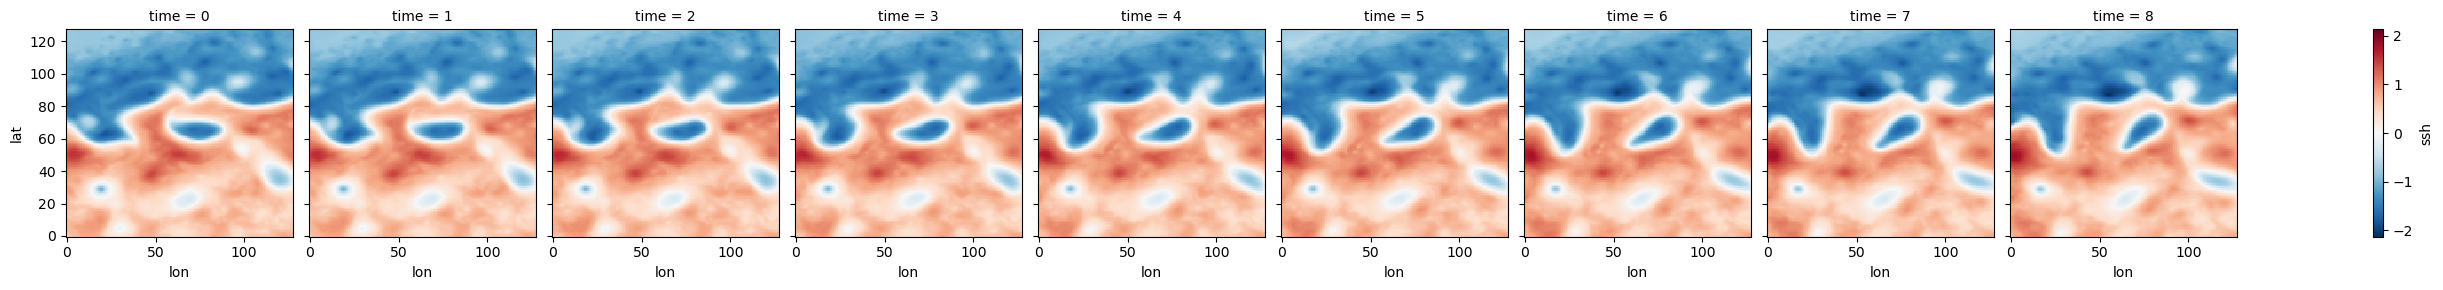

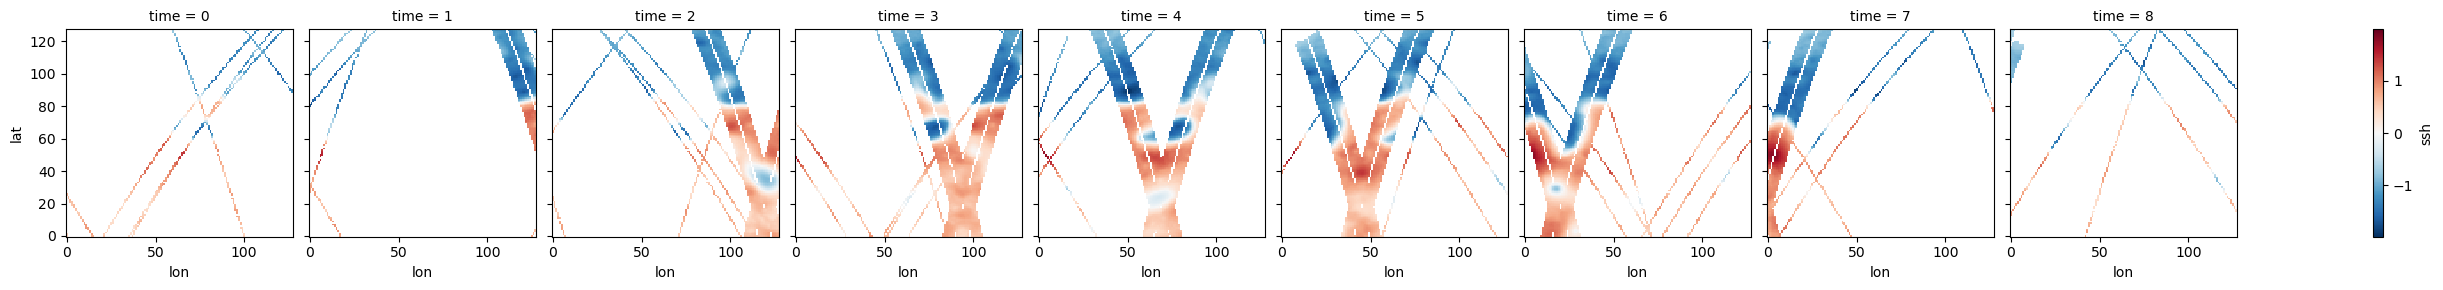

In [20]:
batch = next(iter(datamodule.train_dataloader()))
plot_images(batch.tgt)
plot_images(batch.input)

### Experiments

#### Sampling

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

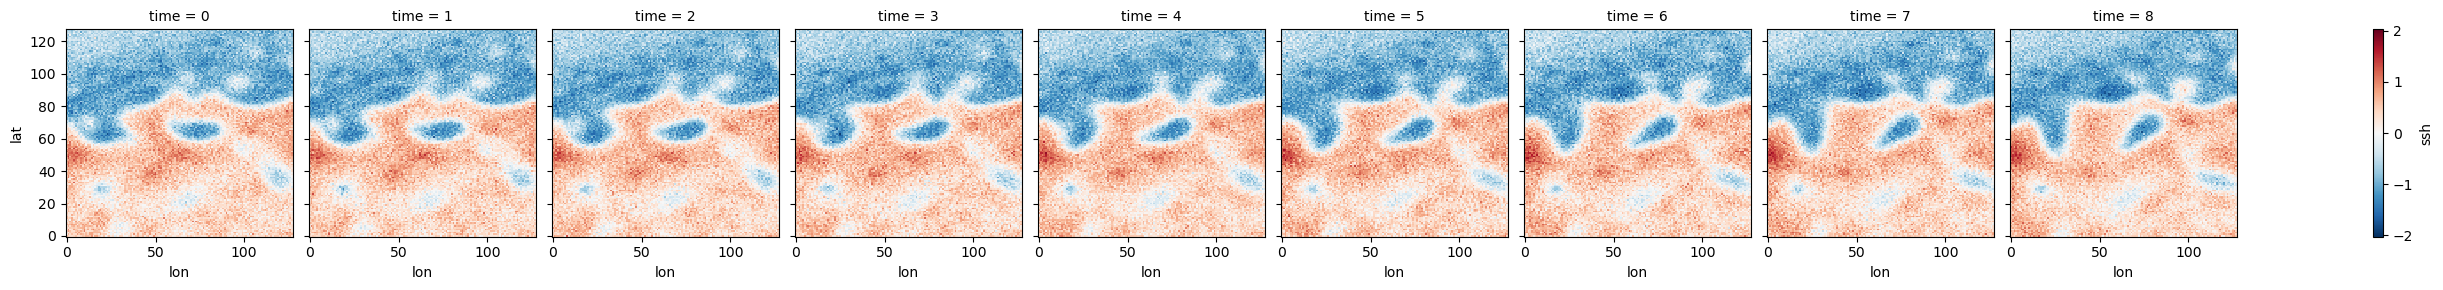

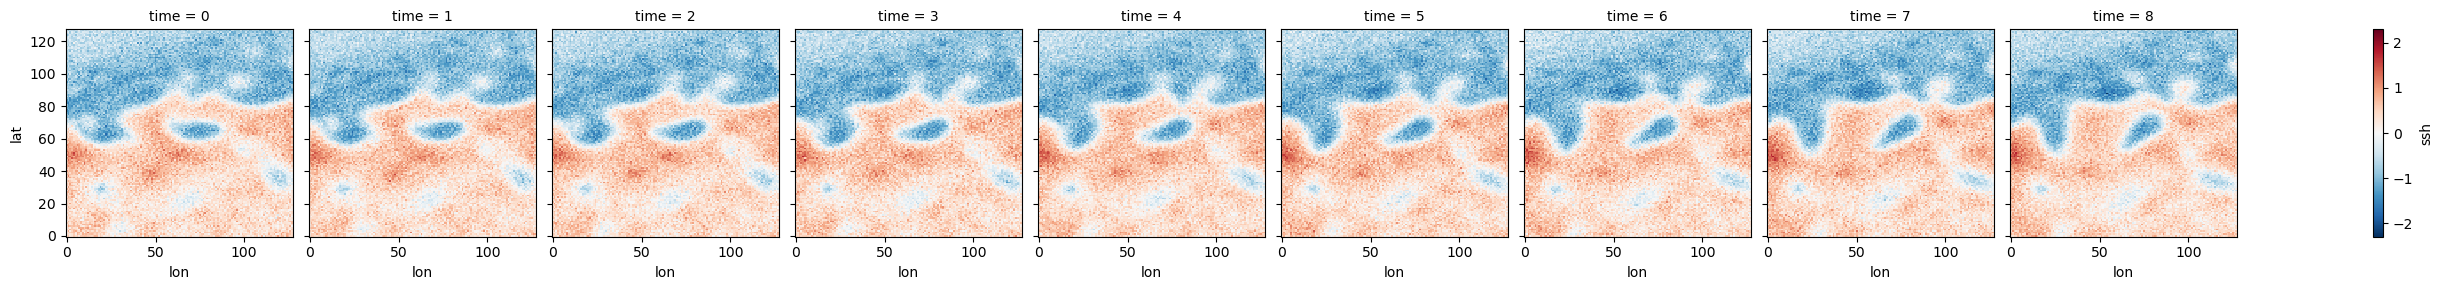

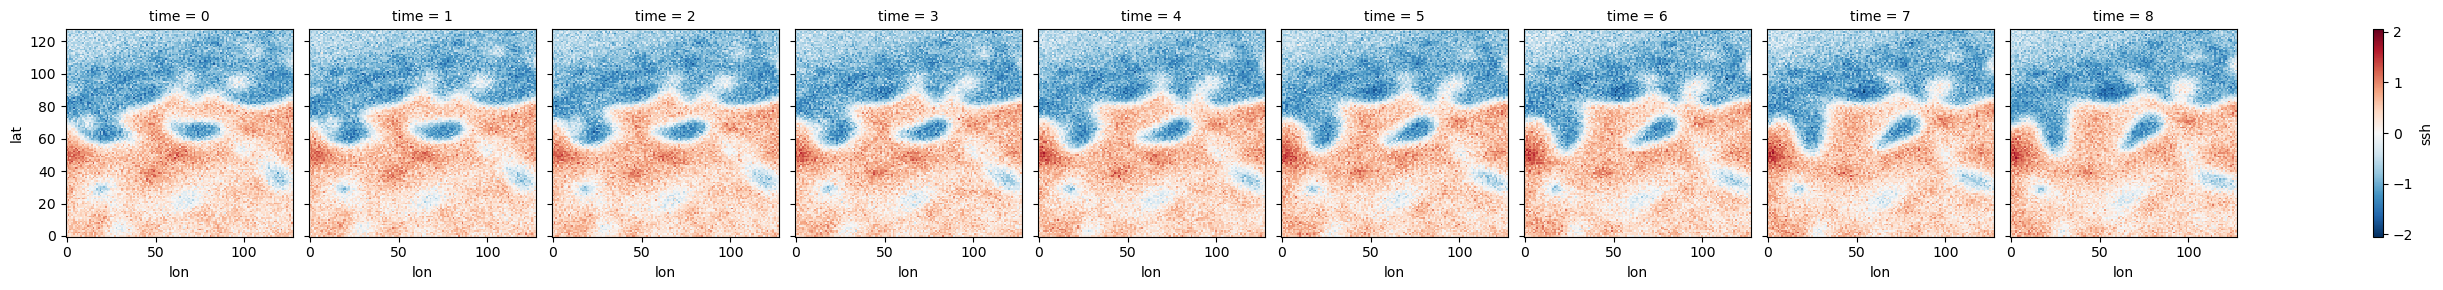

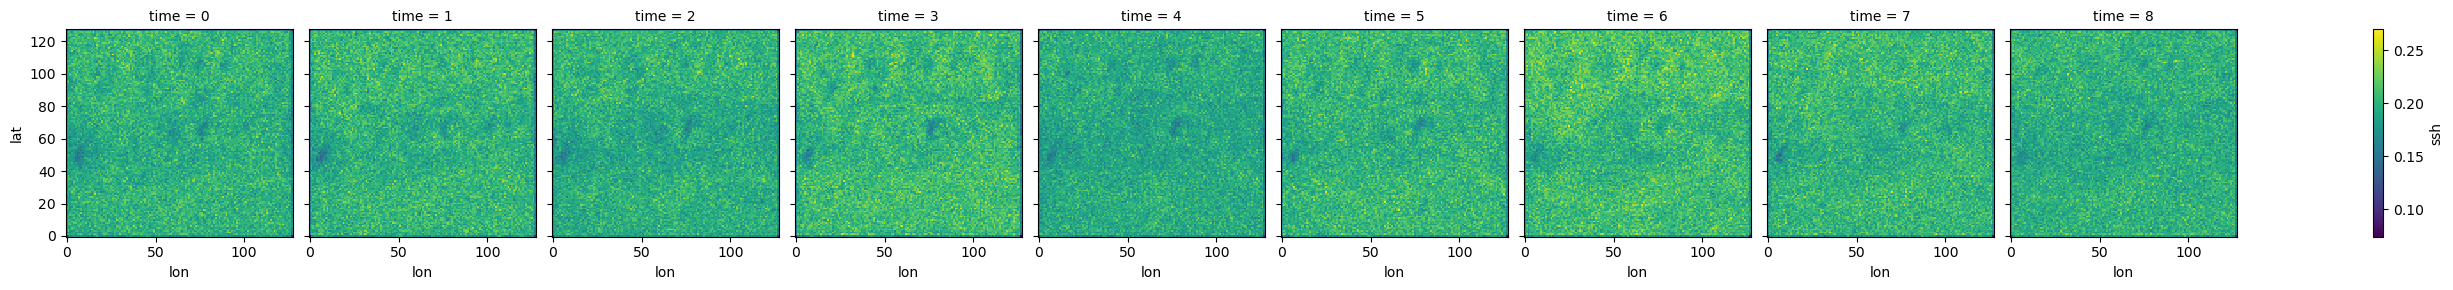

In [21]:
consistency_sampling_and_editing = ConsistencySamplingAndEditingObsCond()

with torch.no_grad():
    samples = []
    for i in range(100):
        sample = consistency_sampling_and_editing(
            unet,
            torch.randn((1, 9, 128, 128), device=device, dtype=dtype),
            batch.input.nan_to_num().to(device).to(dtype),
            ~torch.isnan(batch.input.nan_to_num()).to(device),#.to(dtype),           
            sigmas=[80.0],  # Use more steps for better samples e.g 2-5
            #sigmas=(80.0, 24.4, 5.84, 0.9, 0.661),
            clip_denoised=False,
            verbose=True,
        )
        samples.append(sample)

plot_images(samples[1])
plot_images(samples[2])
plot_images(samples[3])
plot_images(torch.std(torch.stack(samples,dim=0),dim=0))